In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:97% !important; }</style>"))

In [2]:
import sys
sys.path.append("/data/phil/lapd-msi/") 
import io
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import tables
%matplotlib notebook
%load_ext autoreload
%autoreload 2
from mpl_toolkits import mplot3d
# import animatplot as amp
import scipy.signal as sig
# import bapsflib
import glob
import os
import re
import pickle
from tqdm.notebook import tqdm 
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool
import re
import pathlib
from functools import reduce
import torch

In [3]:
import modular_ebm

In [164]:
def to_timestamp(string):
    return time.mktime(time.strptime(string, '%Y-%m-%d %H:%M:%S'))

In [7]:
glob_list = sorted(glob.glob("data/downsampled_all/*.npz"))

In [8]:
glob_list

['data/downsampled_all/2021-09-28-16-44-26.npz',
 'data/downsampled_all/2021-10-01-18-17-57.npz',
 'data/downsampled_all/2021-10-12-13-30-15.818047.npz',
 'data/downsampled_all/2021-10-13-03-07-15.252798.npz',
 'data/downsampled_all/2021-10-13-10-10-26.757364.npz',
 'data/downsampled_all/2021-10-13-10-11-36.126027.npz',
 'data/downsampled_all/2021-10-13-10-54-27.373462.npz',
 'data/downsampled_all/2021-10-13-18-33-12.958422.npz',
 'data/downsampled_all/2021-10-14-07-27-10.613072.npz',
 'data/downsampled_all/2021-10-15-01-07-27.673829.npz',
 'data/downsampled_all/2021-10-15-10-56-16.884977.npz',
 'data/downsampled_all/2021-10-15-19-20-53.559339.npz',
 'data/downsampled_all/2021-10-16-14-51-38.688964.npz',
 'data/downsampled_all/2021-10-17-16-34-26.802758.npz',
 'data/downsampled_all/2021-10-18-19-25-54.287189.npz',
 'data/downsampled_all/2021-10-18-23-58-59.193492.npz',
 'data/downsampled_all/2021-10-19-04-32-06.580864.npz',
 'data/downsampled_all/2021-10-19-09-48-27.736192.npz',
 'data

In [5]:
len(glob_list)

824

# Load in data

1512 Bytes/shot

In [173]:
training_set = [
#                 'data/downsampled_all/2022-02-01-18-44-27.100661.npz',  # don't use because it's too diverse
                'data/downsampled_all/2022-03-14-21-14-20.379509.npz',
                'data/downsampled_all/2022-05-18-03-38-37.701144.npz',
                'data/downsampled_all/2022-06-18-17-04-50.921828.npz',
                'data/downsampled_all/2022-07-18-09-53-11.994800.npz'
               ]

In [174]:
validation_set = ['data/downsampled_all/' + '2022-03-26-22-29-26.046163.npz',
                  'data/downsampled_all/' + 'Big_LaB6_Upgrade 194 03-Isat-p31-Thompson-Hepuff-EW.npz',
                  'data/downsampled_all/' + 'Carter_Experimental 158 13_Hairpin_Langmuir_plane_800G.npz',
                  'data/downsampled_all/' + 'Chen 78 26_41x1line_C12C14C15_A13A41_400G_puff.npz',
                  'data/downsampled_all/' + 'ICRF_campaign 1632 02_AntennaParams_700G_476MHz_FeedHI_r30cm_0degtilt.npz',
                  'data/downsampled_all/' + 'ICRF_campaign 1732 15_Bdotxlinep23_1kG_476MHz_FeedHI_r30cm_30degtilt.npz',
                  'data/downsampled_all/' + 'ICRF_campaign 1833 02_Phase180_Pos20cm_X31_neProfile.npz',
                  'data/downsampled_all/' + 'ICRF_campaign 1939 40_EB23_East_Line2_91V_400Gto2200G_LmCnfg6_20AmpsV2.npz',
                  'data/downsampled_all/' + 'ICRF_campaign 1983 06_AntParams_HeAr_68E10peakdensity_2kG.npz',
                  'data/downsampled_all/' + 'Koepke 27 20_p24p35_IsatVfloat_xline_MaskSourceShorted_DV150_800G.npz',
                  'data/downsampled_all/' + 'Koepke 95 50_allprobes_By200kHz_Bx196kHz_0V.npz',
                  'data/downsampled_all/' + 'Nonlinear_Alfven_Interactions 2547 22_BC15BC11_A13fscan_1000G_x0y0_17perHe.npz',
                  'data/downsampled_all/' + 'Particle_Transport 52 13_line_valves105V_5500A.npz']

In [175]:
for f in validation_set:
    glob_list.remove('data/downsampled_all/' + f)

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_6075/2730844557.py:2 in <module>                                           │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_6075/2730844557.py'                  │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
ValueError: list.remove(x): x not in list

In [176]:
# training_set = glob_list

In [177]:
np_files = []
shot_filenames = []
for f in training_set:
# for f in validation_set:
    temp = np.load(f)['arr_0']
    np_files.append(temp)
    shot_filenames += ([f] * len(temp))

In [178]:
all_data = np.concatenate(np_files)

In [179]:
num_shots = all_data.shape[0]

In [180]:
all_data.dtype

dtype([('MSI_timestamp', '<f8'), ('datarun_shotnum', '<u4'), ('datarun_timestamp', '<f8'), ('diode_t0', '<f8'), ('discharge_current', '<f4', (32,)), ('discharge_voltage', '<f4', (32,)), ('interferometer', '<f4', (32,)), ('diode_0', '<f4', (32,)), ('diode_1', '<f4', (32,)), ('diode_2', '<f4', (32,)), ('diode_3', '<f4', (32,)), ('diode_4', '<f4', (32,)), ('magent_profile', '<f4', (64,)), ('pressures', '<f4', (51,))])

In [181]:
num_shots

374083

In [182]:
filters = [np.where(np.mean(all_data['discharge_current'][:, 18:21], axis=1) > 1e3)[0]]
#            np.where(np.mean(all_data['discharge_voltage'][:, 18:21], axis=1) < -20)[0],
#            np.where(np.mean(all_data['diode_0'][:, 18:21], axis=1) > 0.2)[0],
#            np.where(np.mean(all_data['diode_1'][:, 18:21], axis=1) > 0.2)[0],
#            np.where(np.mean(all_data['diode_2'][:, 18:21], axis=1) > 0.2)[0]]
idx_remain = np.arange(num_shots)
for idcs in filters:
    idx_remain = np.intersect1d(idx_remain, idcs)

# Cut data

In [183]:
data_remain = all_data[idx_remain]

In [184]:
len(data_remain)

373935

In [185]:
del all_data

In [186]:
discharge_current_cut = np.array([])
discharge_voltage_cut = np.array([])
interferometer_cut = np.array([])

diode_0_cut = reduce(np.union1d, (np.where(np.mean(data_remain['diode_0'][:, 18:21], axis=1) < 0.11)[0],
                                  np.intersect1d(np.where(data_remain['diode_t0'] > 400 + 3.72617e9)[0],
                                                 np.where(data_remain['diode_t0'] < 1747 + 3.72617e9)[0]),
                                  np.intersect1d(np.where(data_remain['diode_t0'] > to_timestamp('2088-2-11 17:37:00'))[0],
                                                 np.where(data_remain['diode_t0'] < to_timestamp('2088-2-11 18:38:00'))[0]),
                                  np.where(np.mean(data_remain['diode_0'][:, 18:21], axis=1) > 10)[0]
                                 ))

diode_1_cut = np.where(np.mean(data_remain['diode_1'][:, 18:21], axis=1) < 0.1)[0]

diode_2_cut = np.array([])

diode_3_cut = np.where(data_remain['diode_t0'] < to_timestamp('2088-1-20 14:30:00'))[0]

diode_4_cut = np.where(data_remain['diode_t0'] < to_timestamp('2088-1-20 14:30:00'))[0]

magnet_profile_cut = np.array([])
pressures_cut = np.array([])

In [187]:
print(diode_0_cut.shape)
print(diode_1_cut.shape)
print(diode_3_cut.shape)
print(diode_4_cut.shape)

(0,)
(0,)
(0,)
(0,)


In [188]:
dtype = np.dtype([('MSI_timestamp', '<f8'), ('datarun_shotnum', '<u4'), ('datarun_timestamp', '<f8'), ('diode_t0', '<f8'),
                  ('discharge_current', '<f4', (32,)), ('discharge_voltage', '<f4', (32,)), ('interferometer', '<f4', (32,)),
                  ('diode_0', '<f4', (32,)), ('diode_1', '<f4', (32,)),('diode_2', '<f4', (32,)), ('diode_3', '<f4', (32,)),
                  ('diode_4', '<f4', (32,)), ('magnet_profile', '<f4', (64,)), ('pressures', '<f4', (51,))])

In [189]:
data_remain = data_remain.astype(dtype)

# Save data

In [190]:
dtype_scale = np.dtype([('discharge_current', '<f4'), ('discharge_voltage', '<f4'), ('interferometer', '<f4'),
                        ('diode_0', '<f4'), ('diode_1', '<f4'),('diode_2', '<f4'), ('diode_3', '<f4'),
                        ('diode_4', '<f4'), ('magnet_profile', '<f4'), ('pressures', '<f4')])

In [191]:
scaling_mult = np.zeros(1, dtype=dtype_scale)
scaling_mult['discharge_current'] = 1e4  # (10 kA)
scaling_mult['discharge_voltage'] = 1e2  # (100 A)
scaling_mult['interferometer'] = 10 # 10 V
scaling_mult['diode_0'] = 10 # 10 V
scaling_mult['diode_1'] = 10 # 10 V
scaling_mult['diode_2'] = 10 # 10 V
scaling_mult['diode_3'] = 10 # 10 V
scaling_mult['diode_4'] = 0.1 # because it's so low anyways V
scaling_mult['magnet_profile'] = 1e3  # 1 kG
scaling_mult['pressures'] = 10

In [192]:
for fieldname in scaling_mult.dtype.names:
    data_remain[fieldname] = data_remain[fieldname] / scaling_mult[fieldname]

In [193]:
np.savez('data/data-MSI-mini_2022-9-28_sets-4-train', signals=data_remain, scale=scaling_mult, discharge_current_cut=discharge_current_cut,
         discharge_voltage_cut=discharge_voltage_cut, interferometer_cut=interferometer_cut,
         diode_0_cut=diode_0_cut, diode_1_cut=diode_1_cut, diode_2_cut=diode_2_cut, diode_3_cut=diode_3_cut, diode_4_cut=diode_4_cut,
         magnet_profile_cut=magnet_profile_cut, pressures_cut=pressures_cut)

# Test data

In [119]:
diode_0_cut.shape

(2447297,)

In [120]:
pressures_cut

array([], dtype=float64)

In [121]:
diode_0_cut

array([  52636,   52637,   52638, ..., 8577546, 8577547, 8577548])

In [85]:
enabled_mask = np.ones((data_remain.shape[0], 2), dtype=bool)

In [86]:
enabled_mask[pressures_cut.astype('i4'), 0] = False

In [4]:
data_test = modular_ebm.load_data('data/data-MSI-all_2022-5-22_17-6-24-valid.npz')

In [5]:
data_test.shape

torch.Size([64468, 381])

In [32]:
np.sum(np.isnan(data_test.numpy()))

0

In [8]:
data_test[:, -10].shape

torch.Size([64468])

In [29]:
torch.(data_test[0:111, 0:32].reshape(111, 16, 2) * (data_test[0:111, -10])).shape

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│ /tmp/ipykernel_117485/1055485245.py:1 in <module>                                         │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_117485/1055485245.py'                │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
RuntimeError: The size of tensor a (2) must match the size of tensor b (111) at non-singleton
dimension 2

# Plot MSI

In [20]:
import matplotlib as mpl
plt.style.use(['dark_background'])
mpl.rcParams['axes.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['figure.facecolor'] = (27/256, 27/256, 27/256)
mpl.rcParams['legend.facecolor'] = (50/256, 50/256, 50/256)
mpl.rcParams['savefig.facecolor'] = (27/256, 27/256, 27/256)
data_color = (0.2, 0.7, 1.0, 1.0)
samp_color = (1.0, 0.7, 0.1, 0.6)
aux_color =(0, 0.9, 0.0, 0.6)

In [60]:
datetime.datetime.fromtimestamp(np.max(data_remain['diode_t0']))

datetime.datetime(2088, 5, 22, 17, 6, 24, 313373)

In [19]:
datetime.datetime.fromtimestamp(3728075047)

datetime.datetime(2088, 2, 19, 16, 24, 7)

<IPython.core.display.Javascript object>


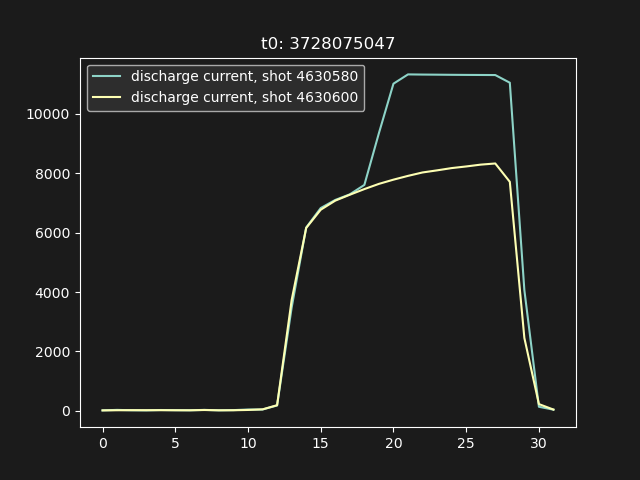

In [39]:
t0 = 3728075047
idx = np.intersect1d(np.where((all_data['diode_t0'] > t0-2))[0], np.where((all_data['diode_t0'] < t0+2))[0])[0]

plt.figure()
plt.title("t0: 3728075047")
plt.plot(all_data[idx]['discharge_current'], label=("discharge current, shot {}".format(idx)))
plt.plot(all_data[idx+20]['discharge_current'], label=("discharge current, shot {}".format(idx+20)))
# plt.plot(all_data[idx]['diode_0'] * 1000, color='cyan', label=("diode, shot {}".format(idx)))
# plt.plot(all_data[idx+1]['diode_0'] * 1000, color='orange', label=("diode, shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


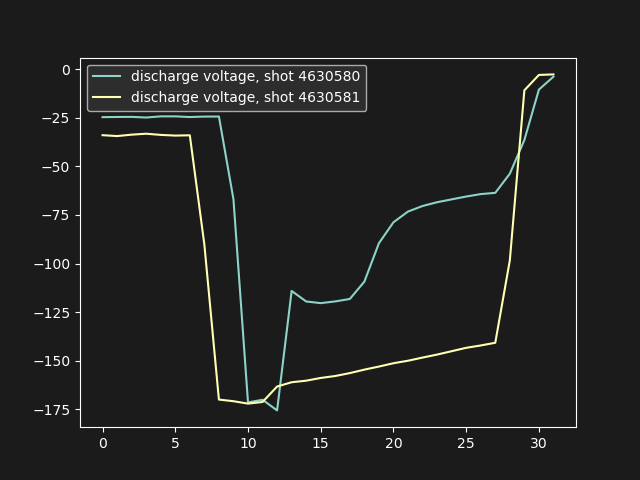

In [22]:
plt.figure()
plt.plot(all_data[idx]['discharge_voltage'], label=("discharge voltage, shot {}".format(idx)))
plt.plot(all_data[idx+1]['discharge_voltage'], label=("discharge voltage, shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


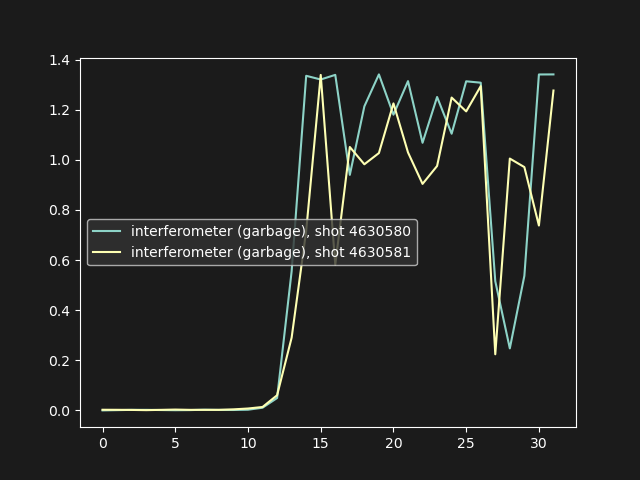

In [24]:
plt.figure()
plt.plot(all_data[idx]['interferometer'], label=("interferometer (garbage), shot {}".format(idx)))
plt.plot(all_data[idx+1]['interferometer'], label=("interferometer (garbage), shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


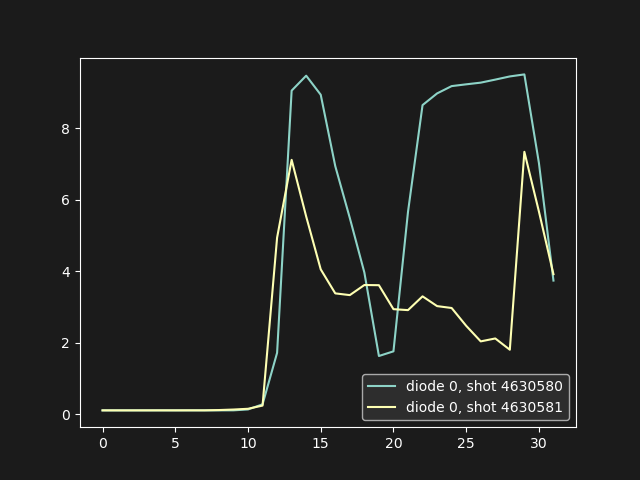

In [25]:
plt.figure()
plt.plot(all_data[idx]['diode_0'], label=("diode 0, shot {}".format(idx)))
plt.plot(all_data[idx+1]['diode_0'], label=("diode 0, shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


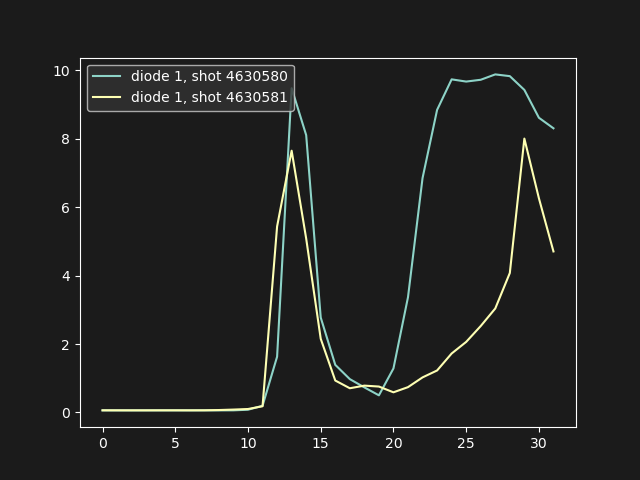

In [26]:
plt.figure()
plt.plot(all_data[idx]['diode_1'], label=("diode 1, shot {}".format(idx)))
plt.plot(all_data[idx+1]['diode_1'], label=("diode 1, shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


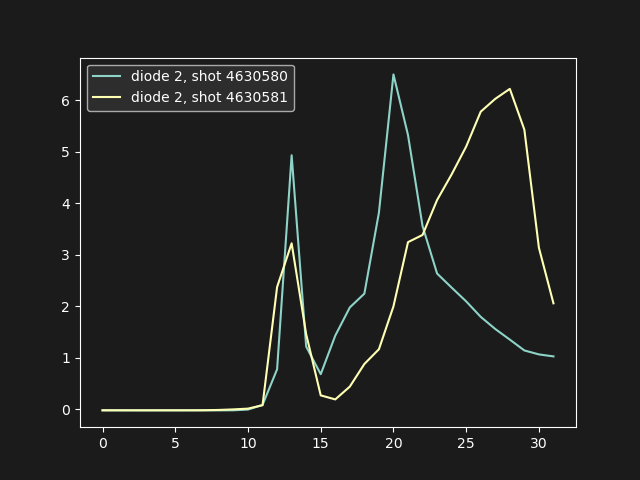

In [27]:
plt.figure()
plt.plot(all_data[idx]['diode_2'], label=("diode 2, shot {}".format(idx)))
plt.plot(all_data[idx+1]['diode_2'], label=("diode 2, shot {}".format(idx+1)))
plt.legend()

<IPython.core.display.Javascript object>


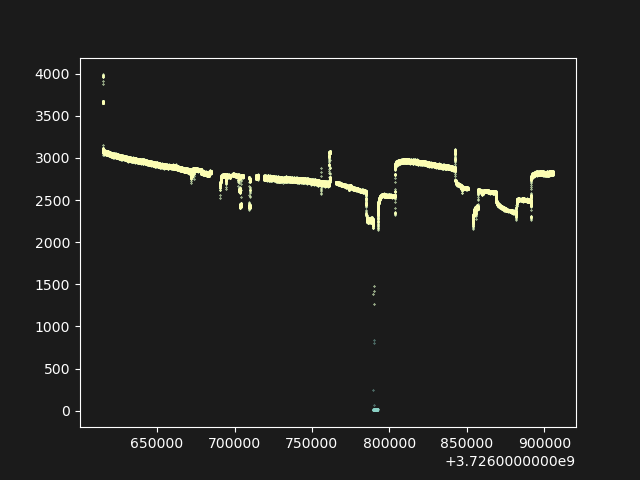

In [20]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['discharge_current'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data[idx_remain]['discharge_current'][:, 18:21], axis=1), s=0.1)
# plt.axvline(time.mktime(time.strptime('2088-4-22 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')
# plt.axvline(time.mktime(time.strptime('2088-4-15 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')
# plt.xlim(time.mktime(time.strptime('2088-1-27 12:20:00', '%Y-%m-%d %H:%M:%S')),
#          time.mktime(time.strptime('2088-1-30 20:20:00', '%Y-%m-%d %H:%M:%S')))

In [139]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['discharge_voltage'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data[idx_remain]['discharge_voltage'][:, 18:21], axis=1), s=0.1)

<IPython.core.display.Javascript object>

In [69]:
 time.mktime(time.strptime('2088-1-19 14:35:00', '%Y-%m-%d %H:%M:%S'))

3725390100.0

<IPython.core.display.Javascript object>


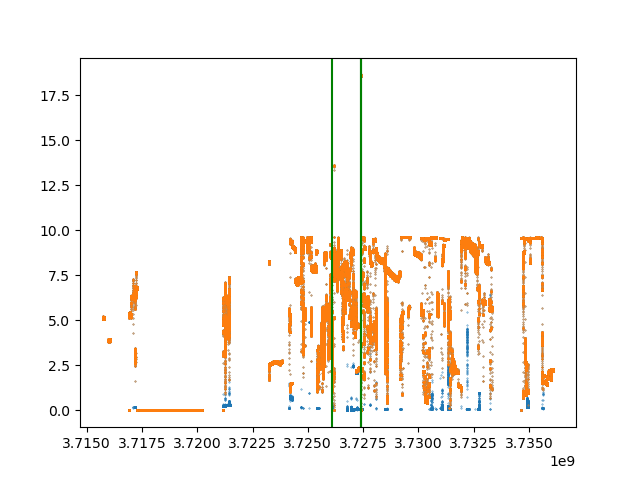

In [188]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['diode_0'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data[idx_remain]['diode_0'][:, 18:21], axis=1), s=0.1)
# plt.axvline(time.mktime(time.strptime('2087-9-28 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')
# plt.axvline(time.mktime(time.strptime('2087-10-19 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2088-1-27 15:20:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2088-2-11 17:37:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2088-2-11 18:38:00', '%Y-%m-%d %H:%M:%S')), color='g')
# plt.xlim(time.mktime(time.strptime('2088-1-27 12:20:00', '%Y-%m-%d %H:%M:%S')),
#          time.mktime(time.strptime('2088-1-30 20:20:00', '%Y-%m-%d %H:%M:%S')))

<IPython.core.display.Javascript object>


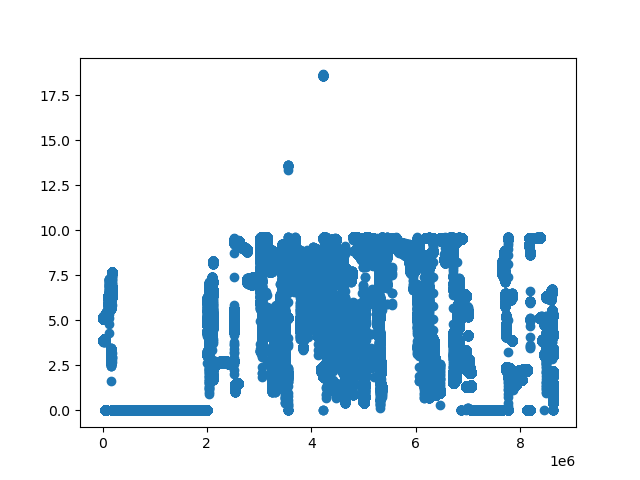

In [198]:
plt.figure()
plt.scatter(np.arange(len(data_remain)), np.mean(data_remain['diode_0'][:, 18:21], axis=1))

<IPython.core.display.Javascript object>


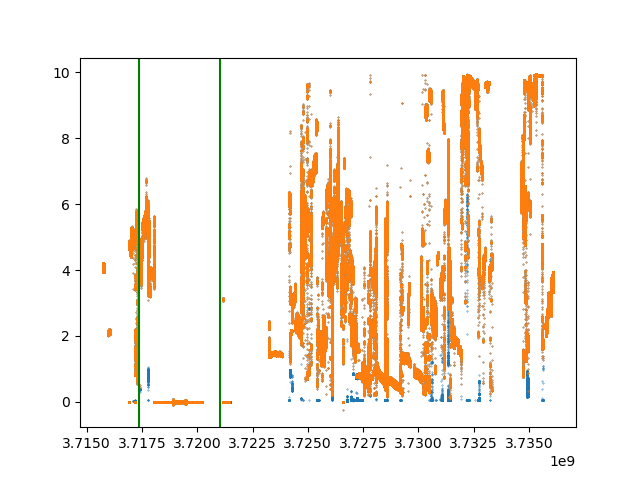

In [141]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['diode_1'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data[idx_remain]['diode_1'][:, 18:21], axis=1), s=0.1)
plt.axvline(time.mktime(time.strptime('2087-10-19 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2087-11-30 00:00:00', '%Y-%m-%d %H:%M:%S')), color='g')

<IPython.core.display.Javascript object>


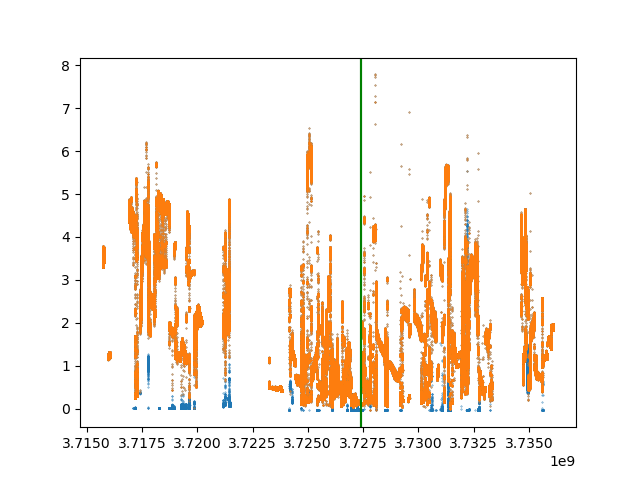

In [151]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['diode_2'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data[idx_remain]['diode_2'][:, 18:21], axis=1), s=0.1)
plt.axvline(time.mktime(time.strptime('2088-2-11 17:37:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2088-2-11 18:38:00', '%Y-%m-%d %H:%M:%S')), color='g')

In [ ]:
372748611

<IPython.core.display.Javascript object>


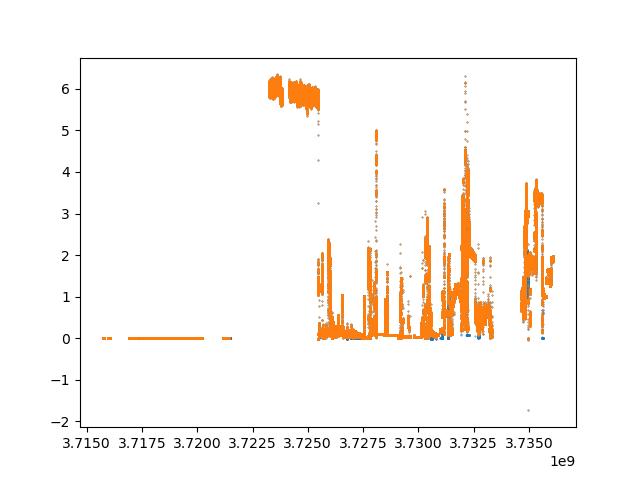

In [143]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['diode_3'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data['diode_3'][idx_remain, 18:21], axis=1), s=0.1)

<IPython.core.display.Javascript object>


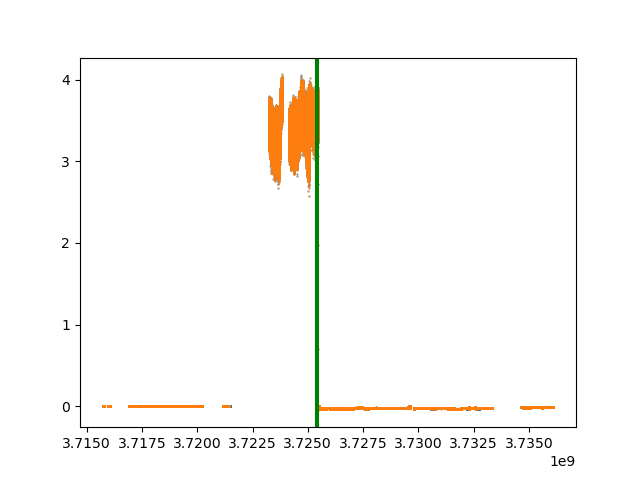

In [144]:
plt.figure()
plt.scatter(all_data['diode_t0'], np.mean(all_data['diode_4'][:, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data['diode_4'][idx_remain, 18:21], axis=1), s=0.1)
plt.axvline(time.mktime(time.strptime('2088-1-19 14:30:00', '%Y-%m-%d %H:%M:%S')), color='g')
plt.axvline(time.mktime(time.strptime('2088-1-20 14:30:00', '%Y-%m-%d %H:%M:%S')), color='g')

<IPython.core.display.Javascript object>


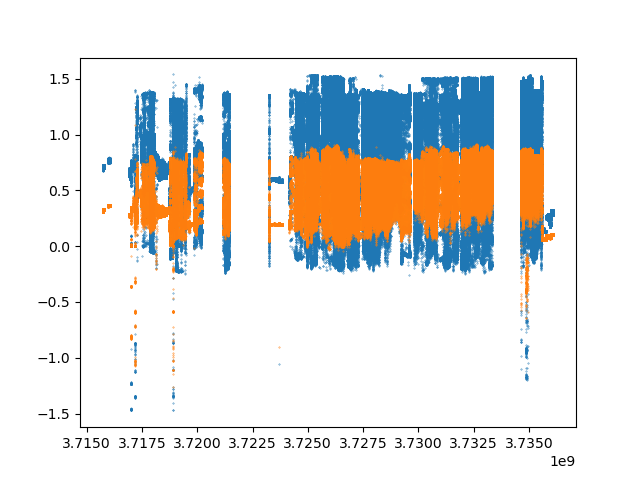

In [145]:
plt.figure()
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data['interferometer'][idx_remain, 18:21], axis=1), s=0.1)
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data['interferometer'][idx_remain, :], axis=1), s=0.1)

<IPython.core.display.Javascript object>


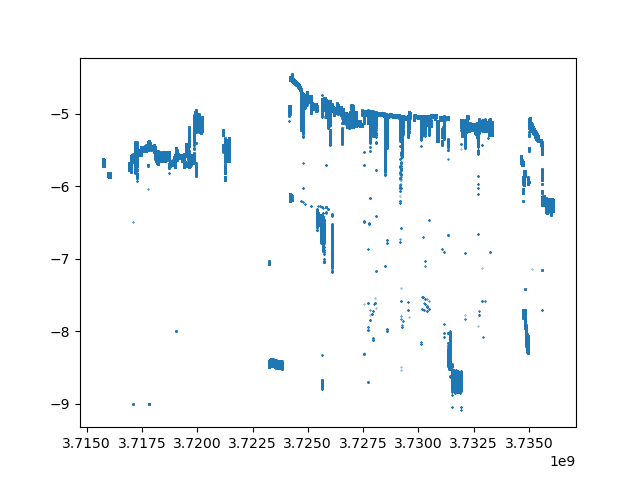

In [146]:
plt.figure()
plt.scatter(all_data['diode_t0'][idx_remain], all_data['pressures'][idx_remain, 0]/np.log(10), s=0.1)

<IPython.core.display.Javascript object>


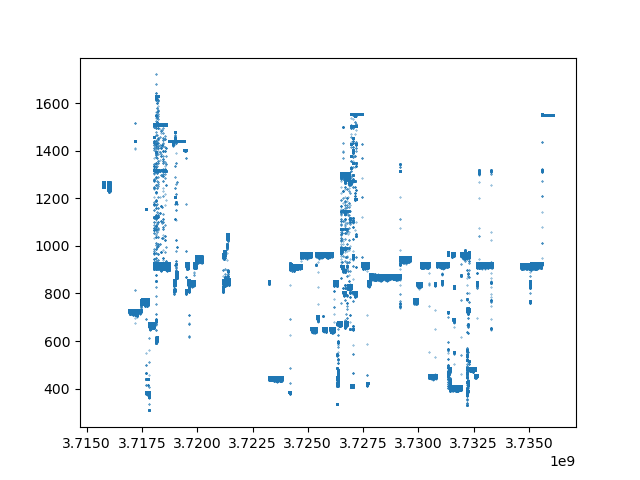

In [147]:
plt.figure()
plt.scatter(all_data['diode_t0'][idx_remain], np.mean(all_data['magent_profile'][idx_remain], axis=1), s=0.1)

<IPython.core.display.Javascript object>


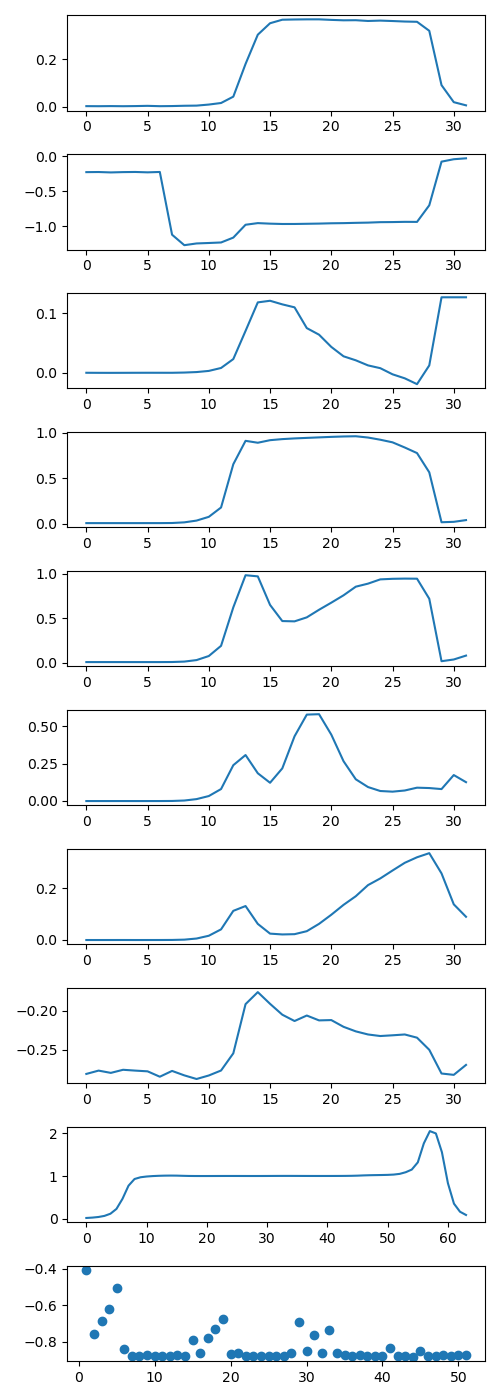

In [55]:
# t0_2 = 3726179366
# index = np.intersect1d(np.where((data_remain['diode_t0'] > t0_2-2))[0], np.where((data_remain['diode_t0'] < t0_2+2))[0])[0]
index=0

fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10,1, figsize=(5,14), sharex=False)
ax1.plot(data_remain['discharge_current'][index])
ax2.plot(data_remain['discharge_voltage'][index])
ax3.plot(data_remain['interferometer'][index])
ax4.plot(data_remain['diode_0'][index])
ax5.plot(data_remain['diode_1'][index])
ax6.plot(data_remain['diode_2'][index])
ax7.plot(data_remain['diode_3'][index])
ax8.plot(data_remain['diode_4'][index])
ax9.plot(data_remain['magnet_profile'][index])
ax10.scatter(np.linspace(1, 51, 51), data_remain['pressures'][index]/np.log(10))
plt.tight_layout()

# Plot all shots or summary subset

In [98]:
data_remain.dtype

dtype([('MSI_timestamp', '<f8'), ('datarun_shotnum', '<u4'), ('datarun_timestamp', '<f8'), ('diode_t0', '<f8'), ('discharge_current', '<f4', (32,)), ('discharge_voltage', '<f4', (32,)), ('interferometer', '<f4', (32,)), ('diode_0', '<f4', (32,)), ('diode_1', '<f4', (32,)), ('diode_2', '<f4', (32,)), ('diode_3', '<f4', (32,)), ('diode_4', '<f4', (32,)), ('magent_profile', '<f4', (64,)), ('pressures', '<f4', (51,))])

In [110]:
data_remain.shape

(73247,)

<IPython.core.display.Javascript object>


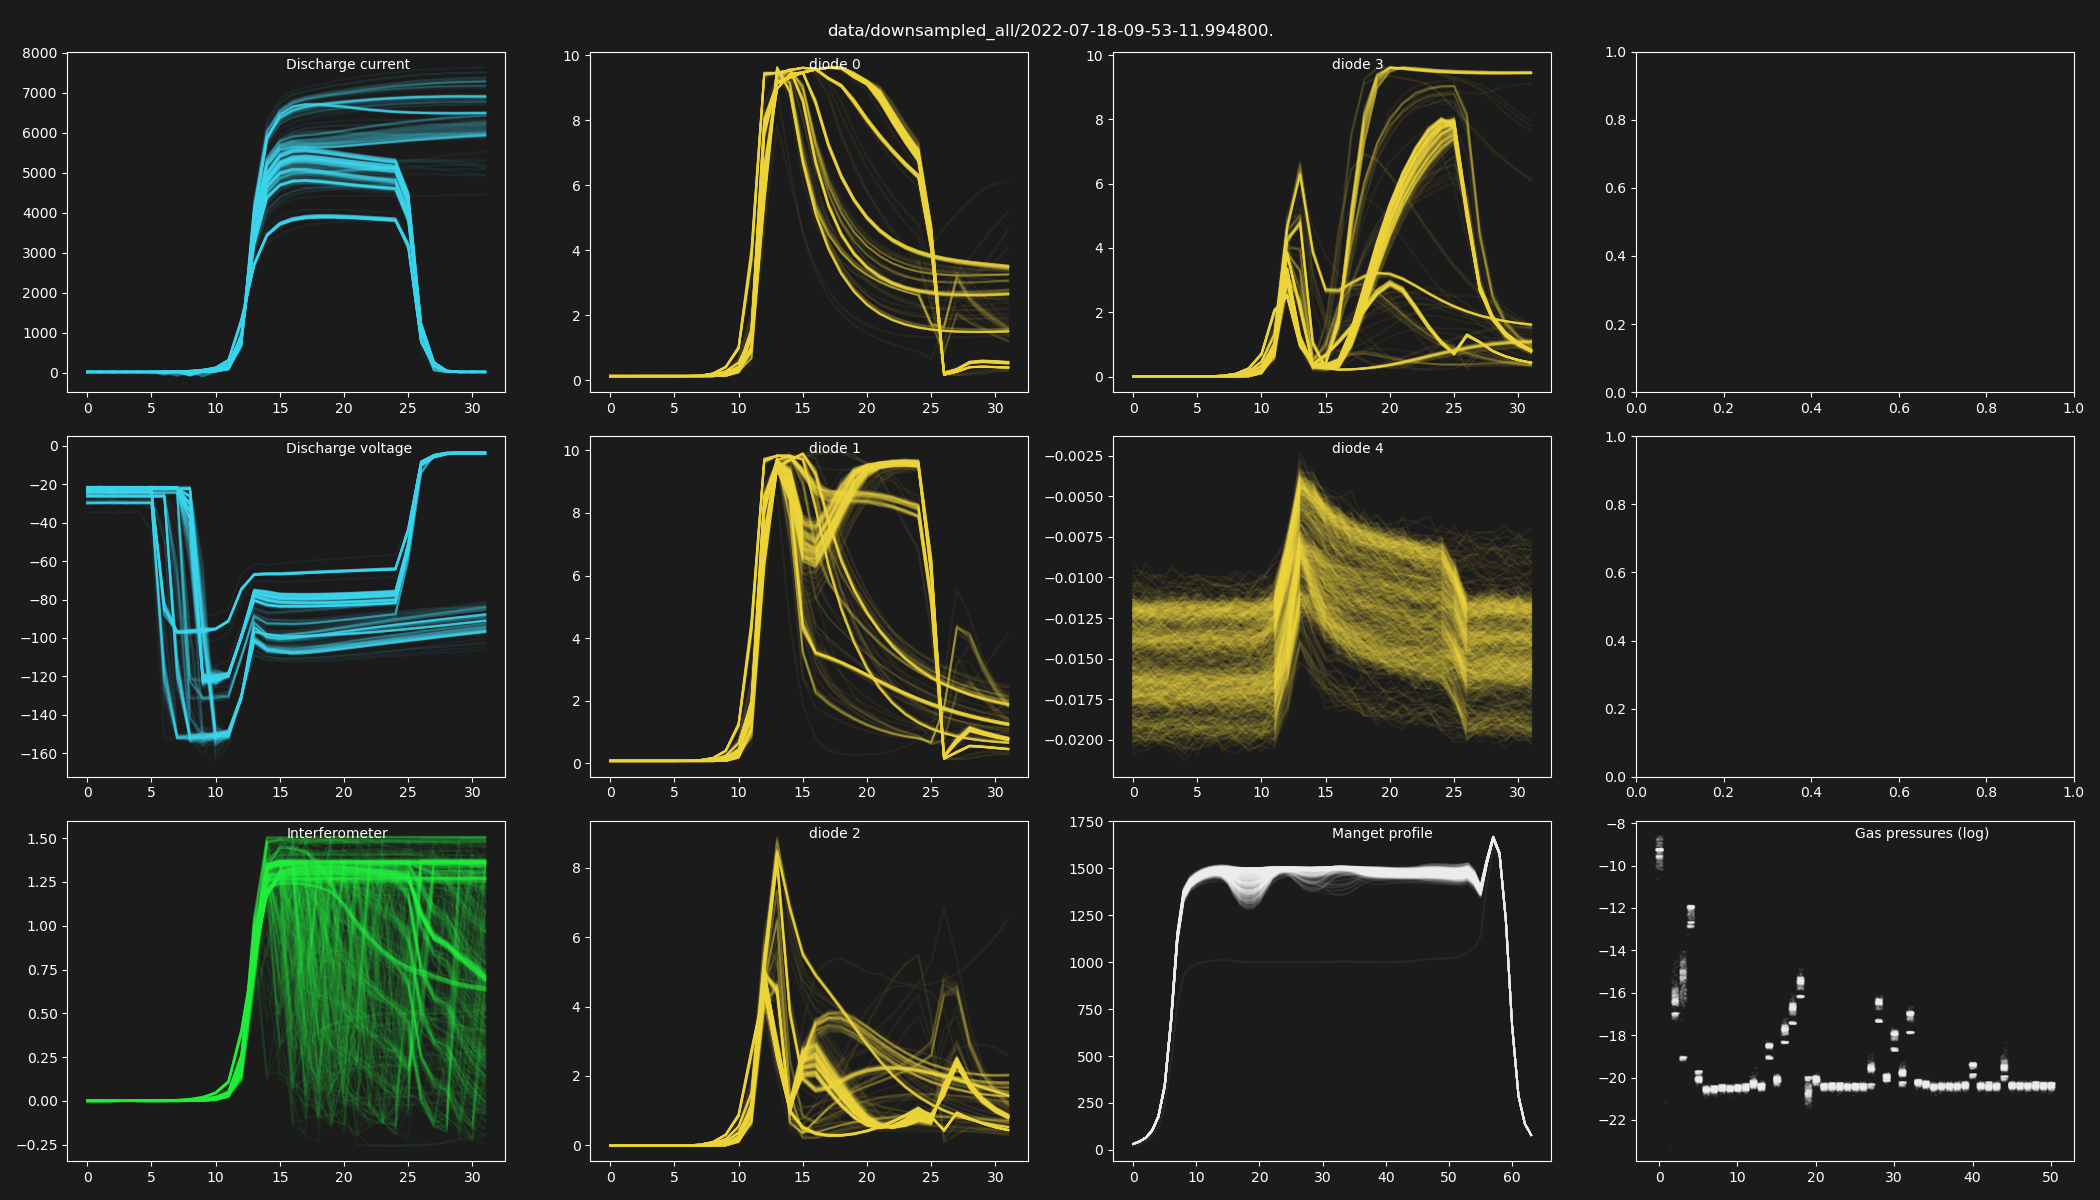

In [111]:
name = shot_filenames[0]

disp_shots = 800 if data_remain.shape[0] > 800 else data_remain.shape[0]
idx = np.linspace(0, data_remain.shape[0] - 1, disp_shots)
idx = np.around(idx).astype(int)

alpha = np.clip(0.05 * 800 / disp_shots, 0.0, 1.0)
c_discharge = [0.3, 0.9, 1.0, alpha]
c_interferometer = [0.2, 1.0, 0.3, alpha]
c_diode = [1.0, 0.9, 0.3, alpha]
c_white = [1.0, 1.0, 1.0, alpha]

# 21"x12" for 16:9 aspect ratio on 25" monitor
fig, ax = plt.subplots(3, 4, figsize=(21, 12))
fig.suptitle(name[:-3])
ax[0, 0].text(0.5, 0.95, 'Discharge current', color='w', transform=ax[0, 0].transAxes)
ax[0, 0].plot(np.arange(data_remain['discharge_current'].shape[1])[np.newaxis, :].T,
              data_remain['discharge_current'][idx, :].T,
              color=c_discharge)

ax[1, 0].text(0.5, 0.95, 'Discharge voltage', color='w', transform=ax[1, 0].transAxes)
ax[1, 0].plot(np.arange(data_remain['discharge_voltage'].shape[1])[np.newaxis, :].T,
              data_remain['discharge_voltage'][idx, :].T,
              color=c_discharge)

ax[2, 0].text(0.5, 0.95, 'Interferometer', color='w', transform=ax[2, 0].transAxes)
ax[2, 0].plot(np.arange(data_remain['interferometer'].shape[1])[np.newaxis, :].T,
              data_remain['interferometer'][idx, :].T,
              color=c_interferometer)

ax[0, 1].text(0.5, 0.95, 'diode 0', color='w', transform=ax[0, 1].transAxes)
ax[0, 1].plot(np.arange(data_remain['diode_0'].shape[1])[np.newaxis, :].T,
              data_remain['diode_0'][idx, :].T,
              c=c_diode)

ax[1, 1].text(0.5, 0.95, 'diode 1', color='w', transform=ax[1, 1].transAxes)
ax[1, 1].plot(np.arange(data_remain['diode_1'].shape[1])[np.newaxis, :].T,
              data_remain['diode_1'][idx, :].T,
              c=c_diode)

ax[2, 1].text(0.5, 0.95, 'diode 2', color='w', transform=ax[2, 1].transAxes)
ax[2, 1].plot(np.arange(data_remain['diode_2'].shape[1])[np.newaxis, :].T,
              data_remain['diode_2'][idx, :].T,
              c=c_diode)

try:
    ax[0, 2].text(0.5, 0.95, 'diode 3', color='w', transform=ax[0, 2].transAxes)
    ax[0, 2].plot(np.arange(data_remain['diode_3'].shape[1])[np.newaxis, :].T,
                  data_remain['diode_3'][idx, :].T,
                  c=c_diode)

    ax[1, 2].text(0.5, 0.95, 'diode 4', color='w', transform=ax[1, 2].transAxes)
    ax[1, 2].plot(np.arange(data_remain['diode_4'].shape[1])[np.newaxis, :].T,
                  data_remain['diode_4'][idx, :].T,
                  c=c_diode)
except:
    print("No north discharge info")

ax[2, 2].text(0.5, 0.95, 'Manget profile', color='w', transform=ax[2, 2].transAxes)
ax[2, 2].plot(data_remain['magent_profile'][idx, :].T,
              c=c_white)

ax[2, 3].text(0.5, 0.95, 'Gas pressures (log)', color='w', transform=ax[2, 3].transAxes)
ax[2, 3].scatter(np.arange(51)[np.newaxis, :] + np.random.uniform(low=-0.4, high=0.4, size=(disp_shots, 1)),
                 data_remain['pressures'][idx, :],
                 c=[c_white], s=0.7)
# Fake plot ot get autoscaling to work correctly. Weird bug.
ax[2, 3].plot(np.arange(51)[np.newaxis, :] + np.zeros((disp_shots, 1)),
              data_remain['pressures'][idx, :], alpha=0)
# ax[2, 3].set_yscale('log')

plt.tight_layout()
plt.savefig("data/summaries/" + name[:-3].replace('data/downsampled_all/', '') + '-traces.png')

In [ ]:
alpha = (0.05 if msi_data.shape[0] > 100000 else 1.0)
# np.clip(0.05 * 800 / disp_shots, 0.0, 1.0)
c_discharge = [0.3, 0.9, 1.0, alpha]
c_interferometer = [0.2, 1.0, 0.3, alpha]
c_diode = [1.0, 0.9, 0.3, alpha]
c_white = [1.0, 1.0, 1.0, alpha]

# Add plots that track over the course of the datarun / days
x_axis = np.arange(msi_data.shape[0])

fig, ax = plt.subplots(3, 4, figsize=(50, 28))
fig.suptitle(name[:-3])
ax[0, 0].text(0.5, 0.95, 'Discharge current', color='w', transform=ax[0, 0].transAxes)
ax[0, 0].scatter(x_axis, np.mean(msi_data['discharge_current'], axis=1), s=1.0, c=[c_discharge])

ax[1, 0].text(0.5, 0.95, 'Discharge voltage', color='w', transform=ax[1, 0].transAxes)
ax[1, 0].scatter(x_axis, np.mean(msi_data['discharge_voltage'], axis=1), s=1.0, c=[c_discharge])

ax[2, 0].text(0.5, 0.95, 'Interferometer', color='w', transform=ax[2, 0].transAxes)
ax[2, 0].scatter(x_axis, np.mean(msi_data['interferometer_signals'][:, 0, :], axis=1), s=1.0, c=[c_interferometer])

ax[0, 1].text(0.5, 0.95, 'diode 0', color='w', transform=ax[0, 1].transAxes)
ax[0, 1].scatter(x_axis, np.mean(msi_data['diode_signals'][:, 0, :], axis=1), s=1.0, c=[c_diode])

ax[1, 1].text(0.5, 0.95, 'diode 1', color='w', transform=ax[1, 1].transAxes)
ax[1, 1].scatter(x_axis, np.mean(msi_data['diode_signals'][:, 1, :], axis=1), s=1.0, c=[c_diode])

ax[2, 1].text(0.5, 0.95, 'diode 2', color='w', transform=ax[2, 1].transAxes)
ax[2, 1].scatter(x_axis, np.mean(msi_data['diode_signals'][:, 2, :], axis=1), s=1.0, c=[c_diode])

try:
    ax[0, 2].text(0.5, 0.95, 'diode 3', color='w', transform=ax[0, 2].transAxes)
    ax[0, 2].scatter(x_axis, np.mean(msi_data['north_discharge_current'], axis=1), s=1.0, c=[c_diode])

    ax[1, 2].text(0.5, 0.95, 'diode 4', color='w', transform=ax[1, 2].transAxes)
    ax[1, 2].scatter(x_axis, np.mean(msi_data['north_discharge_voltage'], axis=1), s=1.0, c=[c_diode])
except:
    pass

ax[2, 2].text(0.5, 0.95, 'Manget profile', color='w', transform=ax[2, 2].transAxes)
ax[2, 2].scatter(x_axis, np.mean(msi_data['magnet_profile'], axis=1), s=1.0, c=[c_white])

ax[2, 3].set_yscale('log')
ax[2, 3].text(0.5, 0.95, 'Gas pressures (log)', color='w', transform=ax[2, 3].transAxes)
ax[2, 3].scatter(x_axis, (msi_data['pressure_fill'][:]), s=1.0, c=[c_white], alpha=0.05)
ax[2, 3].text(0, msi_data['pressure_fill'][0] + 1e-11, f'0')
for i in range(40):
    ax[2, 3].scatter(x_axis, (msi_data['RGA_partials'][:, i]), s=0.1,
                     c=[mpl.cm.get_cmap('Pastel1')((i % 7) / 6)], alpha=0.09)
    # to avoid text from going off the bottom and ruining tight_layout
    if ax[2, 3].get_ylim()[0] < msi_data['RGA_partials'][i * msi_data.shape[0] // 40, i]:
        ax[2, 3].text(0 + i * msi_data.shape[0] // 40,
                      msi_data['RGA_partials'][i * msi_data.shape[0] // 40, i] + 1e-11, f'{i + 1}')

plt.tight_layout()